In [86]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle
from scipy.signal import butter, lfilter
from scipy.interpolate import CubicSpline
from scipy.ndimage import convolve1d

def low_pass_filter_gaussian(data, sigma=1.0):
    """
    Apply a low-pass Gaussian filter along the time axis (axis=0).

    Parameters:
    - data: np.ndarray of shape (T, D), where T is time and D is feature dimension (128).
    - sigma: Standard deviation of the Gaussian kernel (higher = more smoothing).

    Returns:
    - filtered: np.ndarray of shape (T, D) after smoothing.
    """
    return gaussian_filter1d(data, sigma=sigma, axis=0, mode='nearest')

def low_pass_filter_moving_average(data, window_size=3):
    """
    Apply a moving average filter along the time axis (axis=0).

    Parameters:
    - data: np.ndarray of shape (T, D)
    - window_size: int, must be odd

    Returns:
    - filtered: np.ndarray of shape (T, D)
    """
    if window_size % 2 == 0:
        raise ValueError("window_size must be odd")
    
    pad = window_size // 2
    padded = np.pad(data, ((pad, pad), (0, 0)), mode='edge')
    filtered = np.zeros_like(data)
    
    for i in range(data.shape[0]):
        filtered[i] = np.mean(padded[i:i + window_size], axis=0)
    
    return filtered

from scipy.signal import savgol_filter

def low_pass_filter_savgol(data, window_length=5, polyorder=2):
    """
    Apply Savitzky-Golay filter along time axis (axis=0).

    Parameters:
    - data: np.ndarray of shape (T, D)
    - window_length: must be odd and <= T
    - polyorder: degree of polynomial (usually 2 or 3)

    Returns:
    - filtered: np.ndarray of same shape
    """
    if window_length % 2 == 0:
        window_length += 1  # make it odd
    return savgol_filter(data, window_length=window_length, polyorder=polyorder, axis=0, mode='nearest')


def low_pass_filter_spline(data):
    """
    Apply cubic spline interpolation for smoothing.

    Returns:
    - filtered: np.ndarray of shape (T, D)
    """
    T = data.shape[0]
    x = np.arange(T)
    return np.stack([CubicSpline(x, data[:, i])(x) for i in range(data.shape[1])], axis=1)

def low_pass_filter_tv(data, weight=0.1):
    """
    Apply Total Variation denoising along time axis.

    Parameters:
    - data: np.ndarray of shape (T, D)
    - weight: float, larger = smoother, smaller = more detail preserved

    Returns:
    - filtered: np.ndarray of shape (T, D)
    """
    return np.stack([denoise_tv_chambolle(data[:, i], weight=weight) for i in range(data.shape[1])], axis=1)


def low_pass_filter_butter(data, cutoff=0.25, order=2):
    """
    Apply Butterworth low-pass filter using lfilter (one-pass, works on short sequences).
    """
    b, a = butter(order, cutoff, btype='low', analog=False)
    return np.stack([lfilter(b, a, data[:, i]) for i in range(data.shape[1])], axis=1)

def laplacian_filter_1d(data, bc=False):
    """
    Apply discrete Laplacian filter [1, -2, 1] along time axis.
    
    Parameters:
    - data: np.ndarray of shape (T, D)
    
    Returns:
    - laplacian: np.ndarray of shape (T, D)
    """
    kernel = np.array([1, -2, 1])
    out_data = convolve1d(data, kernel, axis=0, mode='nearest')
    if bc:
        out_data[0] = 0 * out_data[0]
        out_data[-1] = 0 * out_data[-1]
    return out_data

def laplacian_smoothing(data, lambda_weight=0.5, bc=False):
    """
    Apply Laplacian smoothing (original - λ * laplacian) over time.

    Parameters:
    - data: np.ndarray of shape (T, D)
    - lambda_weight: smoothing strength

    Returns:
    - smoothed: np.ndarray of shape (T, D)
    """
    lap = laplacian_filter_1d(data, bc=bc)
    return data + (lambda_weight * lap)


# --- 시각화 (3개의 feature 차원 선택해서 시간에 따라 그리기) ---
def visualize_features_over_time(data, filtered, sigma=1.0, dims=[0, 1, 2]):
    time = np.arange(data.shape[0])
    
    plt.figure(figsize=(10, 6))
    for i, dim in enumerate(dims):
        plt.subplot(len(dims), 1, i+1)
        plt.plot(time, data[:, dim], label=f'Original dim {dim}', linestyle='--', marker='o')
        plt.plot(time, filtered[:, dim], label=f'Filtered dim {dim}', linestyle='-', marker='x')
        plt.ylabel(f'Dim {dim}')
        plt.legend()
        if i == len(dims)-1:
            plt.xlabel('Time Step')
    
    plt.suptitle(f'Low-pass')
    plt.tight_layout()
    plt.show()


In [10]:
# --- 예제 데이터 ---
np.random.seed(42)
data = np.random.randn(8, 128)

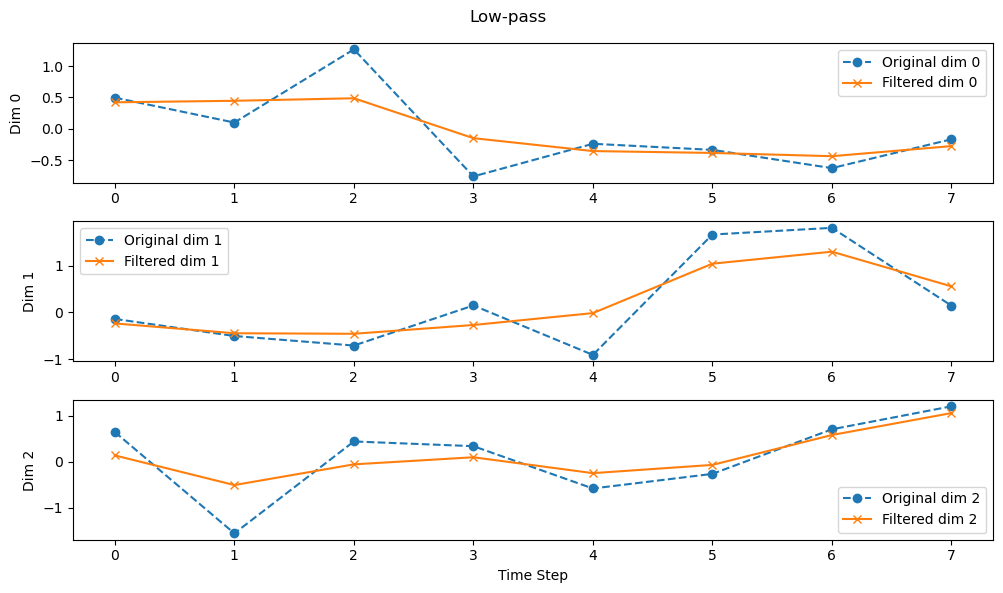

In [33]:
# --- 필터 적용 ---
filtered_data = low_pass_filter_gaussian(data, sigma=.8)

# --- 시각화 실행 ---
visualize_features_over_time(data, filtered_data)

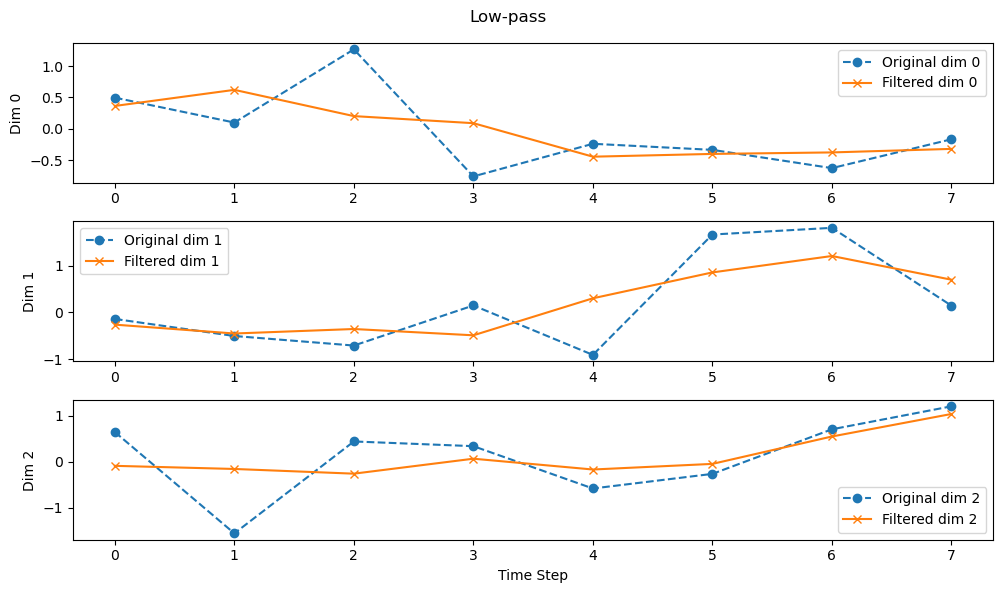

In [36]:

filtered_data = low_pass_filter_moving_average(data, window_size=3)
visualize_features_over_time(data, filtered_data)

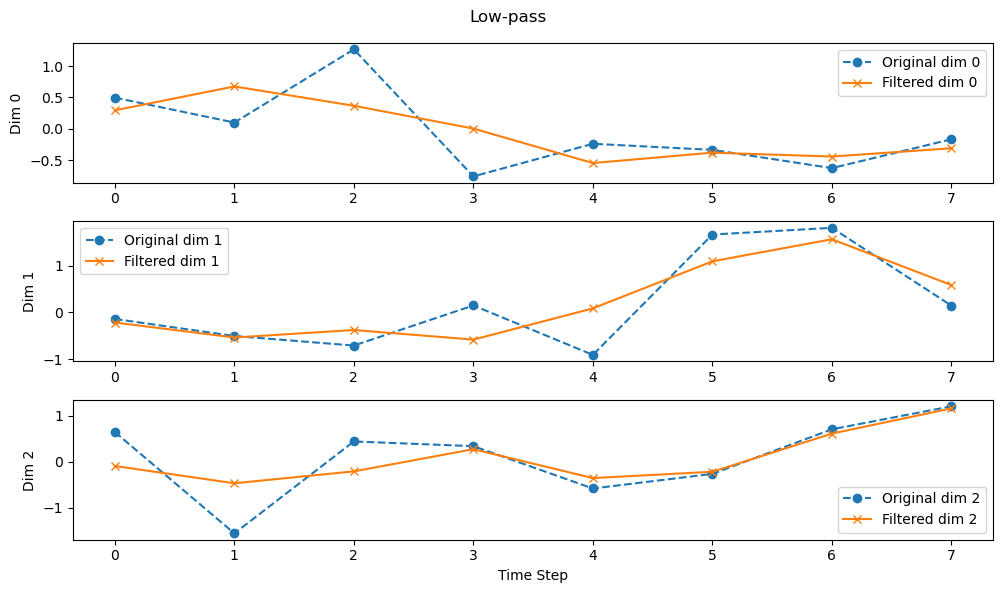

In [47]:


# --- 필터 적용 ---
filtered_data = low_pass_filter_savgol(data, window_length=5, polyorder=3)

# --- 시각화 함수 재사용 ---
visualize_features_over_time(data, filtered_data)


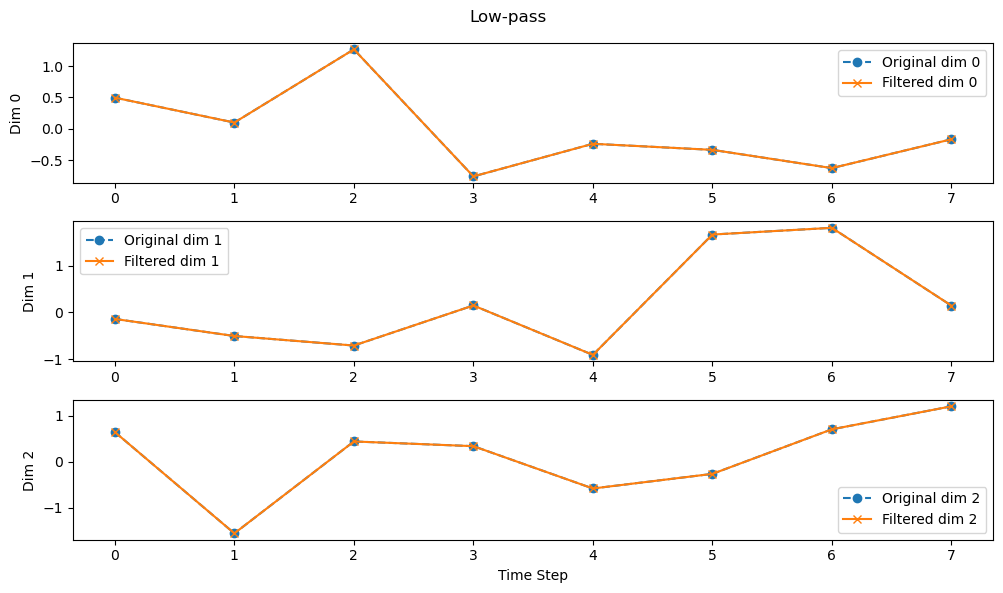

In [48]:


filtered_data = low_pass_filter_spline(data)
visualize_features_over_time(data, filtered_data)

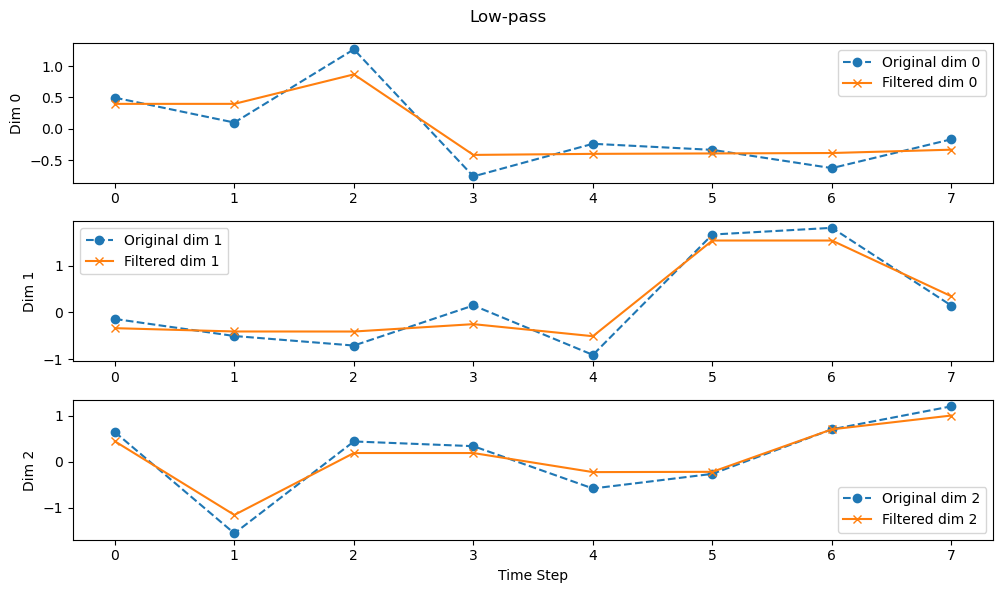

In [52]:
filtered_data = low_pass_filter_tv(data, weight=0.2)
visualize_features_over_time(data, filtered_data)


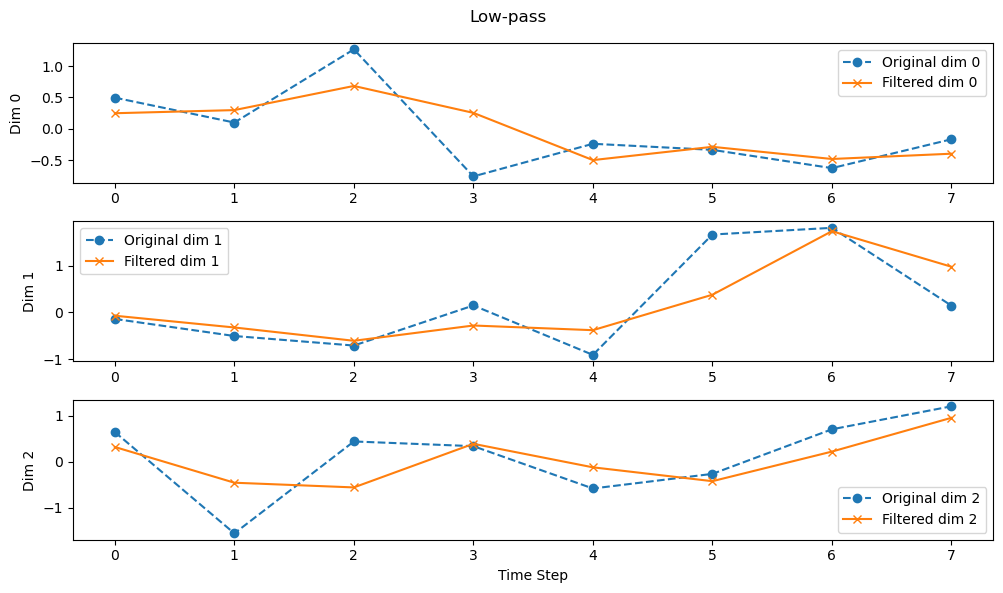

In [60]:
filtered_data = low_pass_filter_butter(data, cutoff=0.5, order=1)
visualize_features_over_time(data, filtered_data)

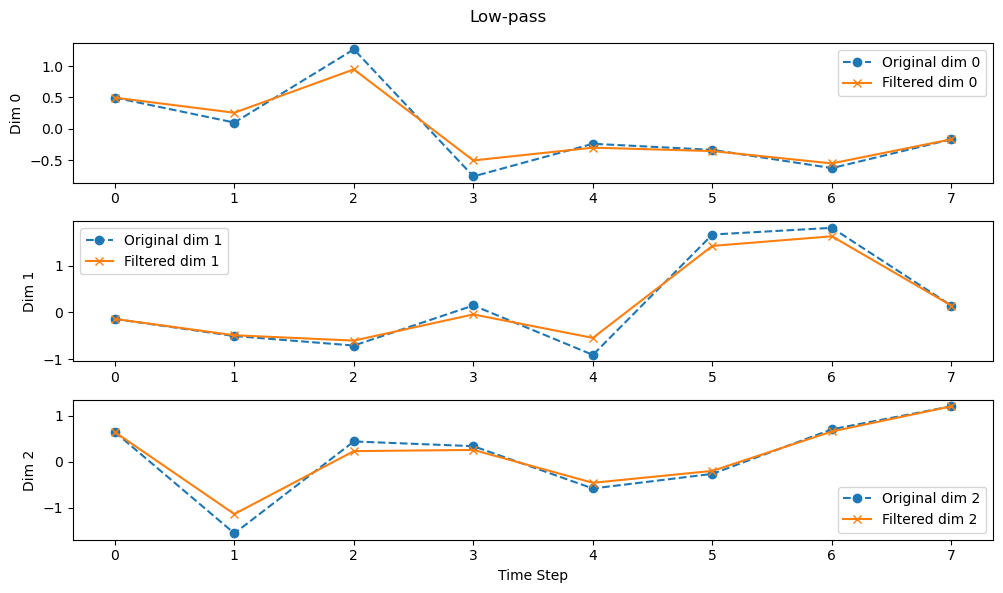

In [90]:
filtered_data = laplacian_smoothing(data, lambda_weight=.1, bc=True)
visualize_features_over_time(data, filtered_data)

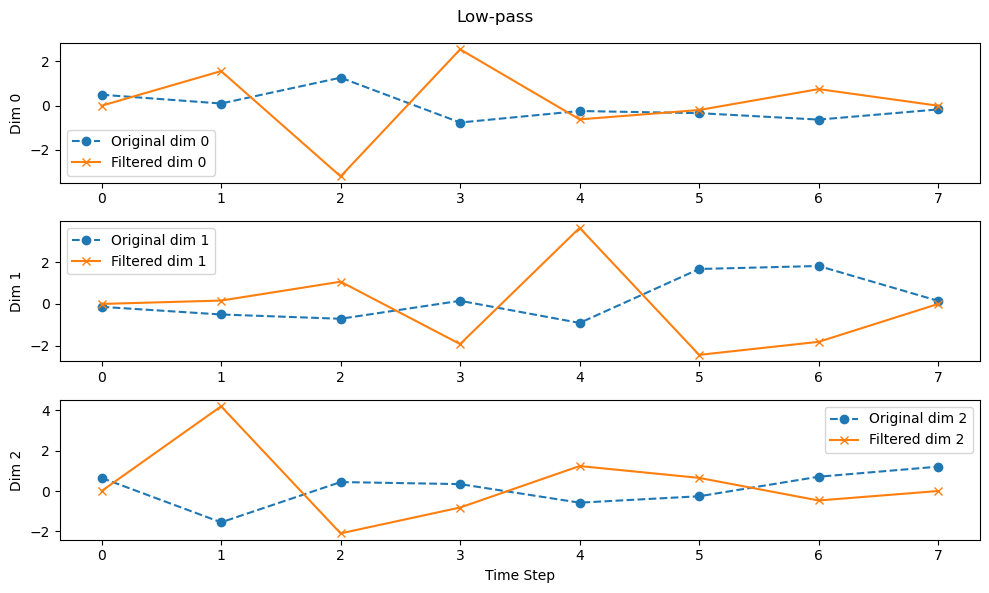

In [81]:

filtered_data = laplacian_filter_1d(data,bc=True)
visualize_features_over_time(data, filtered_data)

In [89]:
filtered_data = laplacian_filter_1d(data,bc=True)
filtered_data[-1]

array([-0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0., -0., -0.,
       -0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,
       -0.,  0., -0.,  0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,
        0.,  0., -0., -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,
        0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,  0., -0.,
       -0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0.,
       -0., -0., -0.,  0., -0., -0., -0.,  0.,  0.,  0., -0.,  0., -0.,
        0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.])